# Project demonstration

This notebook serves as a demonstration of what the toolbox can do. This project is a work in progress, so there will be updates to the code and subsequently the applications. Below are some highlights of what is currently possible.

## Datasets

The starting point of the project is the ability to easily load chemical datasets into a format that is usable from a Machine Learning perspective. All the relevant datasets make use of **SMILES** (Simplified molecular-input line-entry system) to store information on molecules. The in-built DataSets then take the SMILES representation of molecules together with a target array and any other additional information, and load then into **graphs**.

Below are some examples of dataset that can, similarly to the torch datasets, download and load a dataset from the internet.

### LogP dataset

In [14]:
from grape.datasets import LogP
data = LogP(log=True)

SMILES c1cc(C)ccc1O[Si]12OCCN(CCO1)CCO2 in index 4816 contains the atom Si that is not permitted and will be ignored.
SMILES CC1=CC=C(O[Si]23OCCN(CCO2)CCO3)C=C1 in index 4817 contains the atom Si that is not permitted and will be ignored.
SMILES [H]C1=C([H])C(=C([H])C([H])=C1O[Si]12OC([H])([H])C([H])([H])N(C([H])([H])C([H])([H])O1)C([H])([H])C([H])([H])O2)C([H])([H])[H] in index 4818 contains the atom Si that is not permitted and will be ignored.
SMILES c3cc(C)ccc3O[Si]12OCCN(CCO2)CCO1 in index 4819 contains the atom Si that is not permitted and will be ignored.
SMILES Cc1ccc(cc1)O[Si]12OCCN(CCO1)CCO2 in index 4820 contains the atom Si that is not permitted and will be ignored.
SMILES Cc1ccc(O[Si]23OCCN(CCO2)CCO3)cc1 in index 4821 contains the atom Si that is not permitted and will be ignored.
SMILES c1ccc(Cl)cc1O[Si]12OCCN(CCO1)CCO2 in index 6328 contains the atom Si that is not permitted and will be ignored.
SMILES [H]C1=C([H])C(O[Si]23OC([H])([H])C([H])([H])N(C([H])([H])C([H])([H])O

In [15]:
print(data.smiles[0:5])

['CCC1(c2ccccc2)NC(=O)N(C)C1=O', 'CCC1(c2ccccc2)N=C(O)N(C)C1=O', 'CCN(CC)C(O)=C1C=C2c3cccc4[nH]cc(c34)C[C@H]2N(C)C1', 'CCN(CC)C(=O)C1=CC2c3cccc4[nH]cc(c34)CC2N(C)C1', 'CCN(CC)C(=O)C1=CC2c3cccc4[nH]cc(c34)C[C@H]2N(C)C1']


As seen above, the data loader filters the SMILES based a few different criteria. One of them is a check if rdkit recognizes the SMILES representation as valid, another one is the use of a list of *allowed* atom symbols. After filtering, we can access the information using the regular class notations.

### Example outputs

In [16]:
# SMILES
data.smiles[0:5]

['CCC1(c2ccccc2)NC(=O)N(C)C1=O',
 'CCC1(c2ccccc2)N=C(O)N(C)C1=O',
 'CCN(CC)C(O)=C1C=C2c3cccc4[nH]cc(c34)C[C@H]2N(C)C1',
 'CCN(CC)C(=O)C1=CC2c3cccc4[nH]cc(c34)CC2N(C)C1',
 'CCN(CC)C(=O)C1=CC2c3cccc4[nH]cc(c34)C[C@H]2N(C)C1']

In [17]:
# Their corresponding graphs, saved using the torch geometric Data objects.
data[0:5]

[Data(x=[16, 42], edge_index=[2, 34], edge_attr=[34, 12], y=[1]),
 Data(x=[16, 42], edge_index=[2, 34], edge_attr=[34, 12], y=[1]),
 Data(x=[24, 42], edge_index=[2, 54], edge_attr=[54, 12], y=[1]),
 Data(x=[24, 42], edge_index=[2, 54], edge_attr=[54, 12], y=[1]),
 Data(x=[24, 42], edge_index=[2, 54], edge_attr=[54, 12], y=[1])]

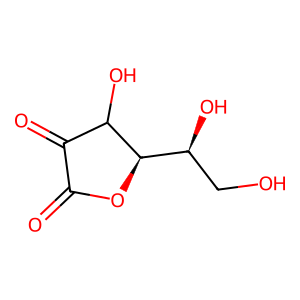

In [18]:
data.draw_smile(10)

In [19]:
# We can also save and load the dataset as such:
#   Dataset are saved using pickle, which allows for fast saving and loading. Saving a dataset and then loading instead of loading from, for example, an excel file is about 10 to 20 times faster.

from grape.utils import DataSet

data.save_dataset('LogP')
loaded_dataset = DataSet(file_path='/Users/faerte/Desktop/grape/notebooks/data/processed/LogP.pickle')
loaded_dataset.smiles[0:5]

File saved at: ./data/processed/LogP.pickle
Loaded dataset.


['CCC1(c2ccccc2)NC(=O)N(C)C1=O',
 'CCC1(c2ccccc2)N=C(O)N(C)C1=O',
 'CCN(CC)C(O)=C1C=C2c3cccc4[nH]cc(c34)C[C@H]2N(C)C1',
 'CCN(CC)C(=O)C1=CC2c3cccc4[nH]cc(c34)CC2N(C)C1',
 'CCN(CC)C(=O)C1=CC2c3cccc4[nH]cc(c34)C[C@H]2N(C)C1']

### Analysis

There are several options to analyze a loaded dataset. Below are some of these options.

#### Compound numbers chart
This chart is generated using a simple clustering algorithm that checks the letter in the SMILES and puts them into the below seen molecule classes. For example, if a SMILES only contains an 'O' and no other class letter, then it is part of 'Oxygenated'. If it contains 'O' and 'Cl', then it is part of 'Multifunctional'.

Loaded dataset.


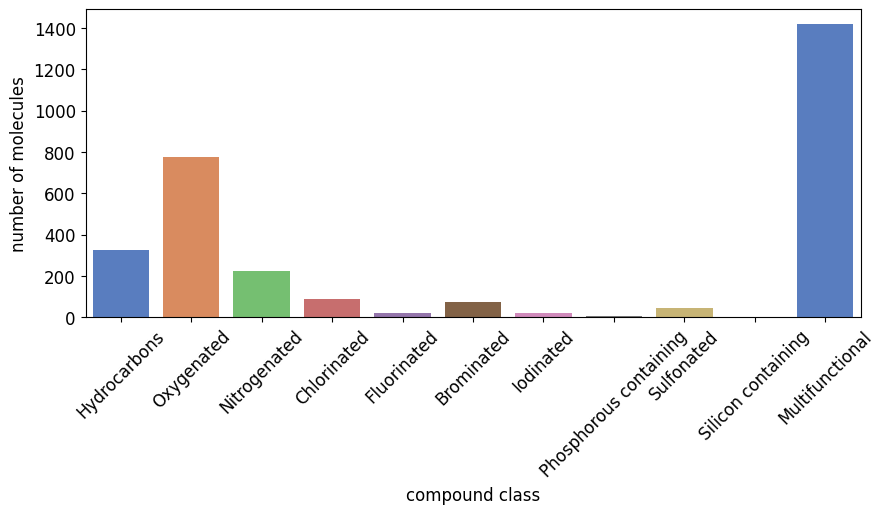

In [20]:
from grape.utils import compound_nums_chart

data = DataSet(file_path='/Users/faerte/Desktop/grape/notebooks/data/processed/BradleyDoublePlus.pickle')
compound_nums_chart(data.smiles, fig_size=(10,4))

#### Classyfire
An almost always more useful clustering is using the Classyfire [1] classification done by Feunang et al.. In code terms, we pull the online documentation of the molecules in question with their Classyfire information, read it and cluster them based on that. This approach is far superior over the simple one above, but can take very long to do (it takes about 2 min to retrieve the information for 100 molecules).

In [21]:
subset_smiles = data.smiles[:100]

from grape.utils import classyfire, classyfire_result_analysis
classyfire(subset_smiles)
smile_classes, class_num_dictionary = classyfire_result_analysis()
print(class_num_dictionary)

100%|██████████| 100/100 [02:56<00:00,  1.77s/it]

{'Hydrocarbons': 36, 'Organosulfur compounds': 5, 'Organohalogen compounds': 10, 'Benzenoids': 15, 'Organic nitrogen compounds': 3, 'Organoheterocyclic compounds': 9, 'Homogeneous non-metal compounds': 5, 'Lipids and lipid-like molecules': 2, 'Organic 1,3-dipolar compounds': 1, 'Organic oxygen compounds': 4, 'Organic acids and derivatives': 8, 'Acetylides': 2}


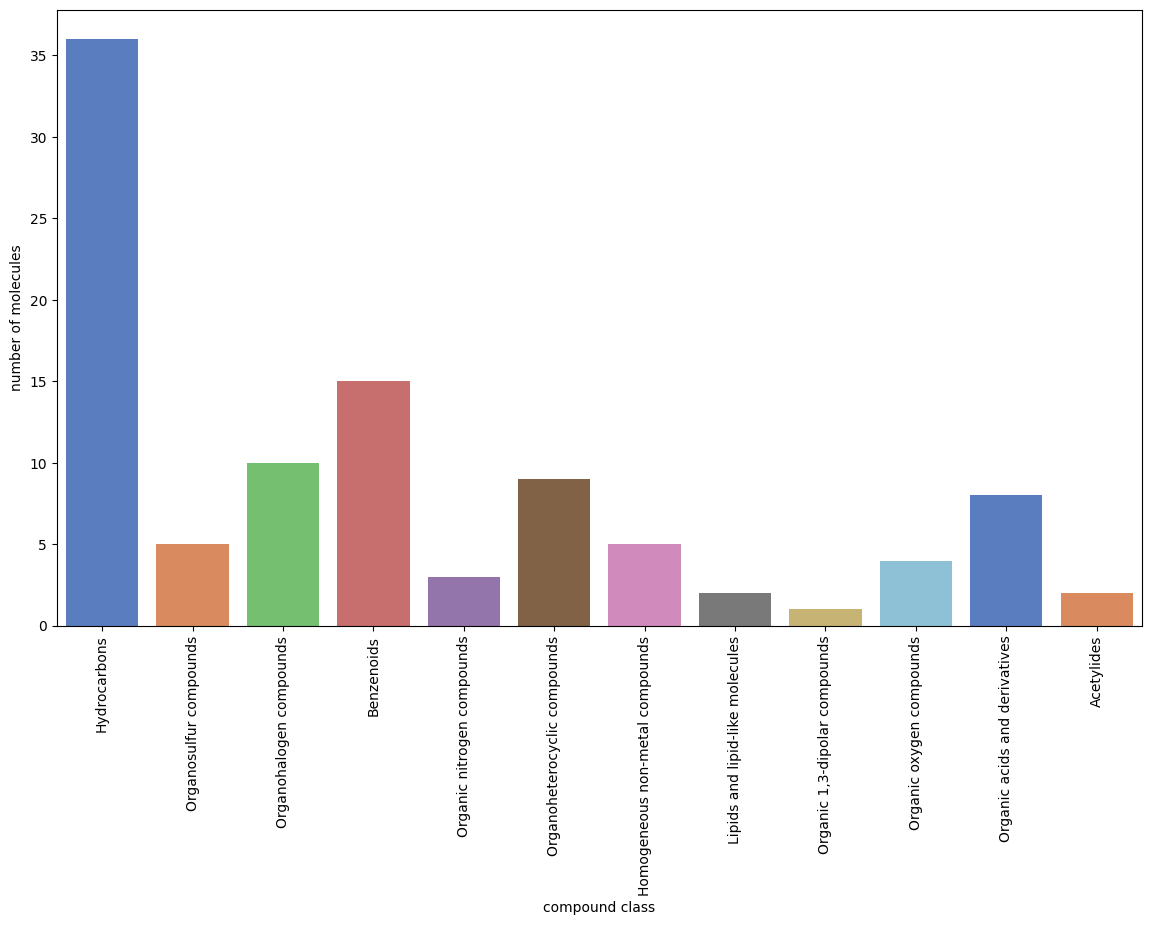

In [22]:
from grape.utils import num_chart
num_chart(class_num_dictionary)

#### Molecule Weight against Target
Another option for visual analysis is to plot the molecule weight against the target attribute. This might give an indication on how molecule size correlates with the target, often a usual observation.

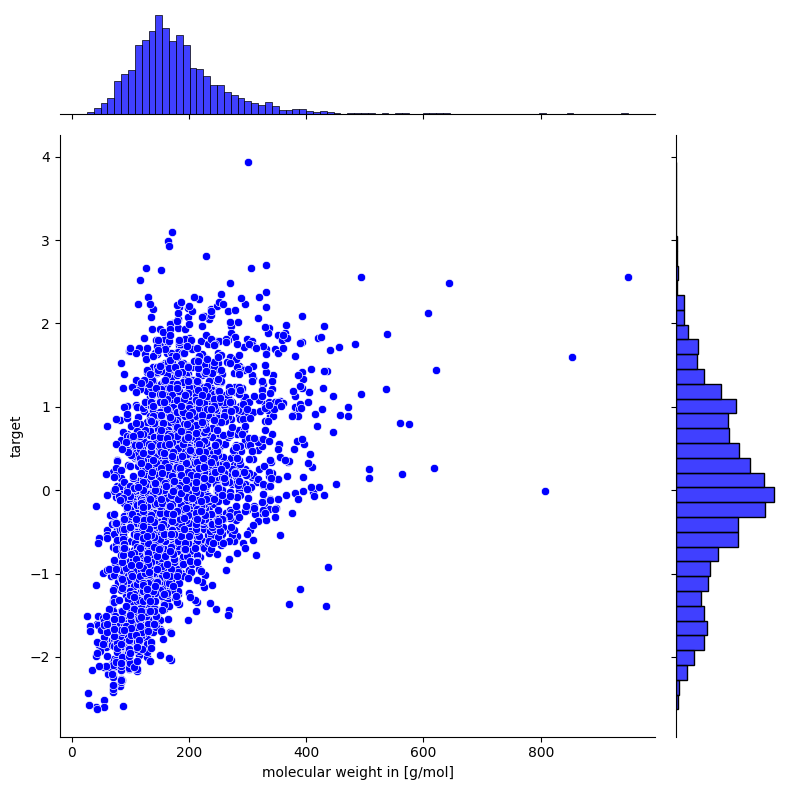

In [23]:
%matplotlib inline
data.weight_vs_target_plot(fig_height=3, save_fig=True)

#### Feature number charts
If only a basic analysis of the dataset, is needed, then one can generate number charts based on the featurizion of the molecules. The implementation is built on top of DGL-LIFESCI ```analyze_mols``` function ([github](https://github.com/awslabs/dgl-lifesci/blob/master/python/dgllife/utils/analysis.py)), below is an example.

Loaded dataset.


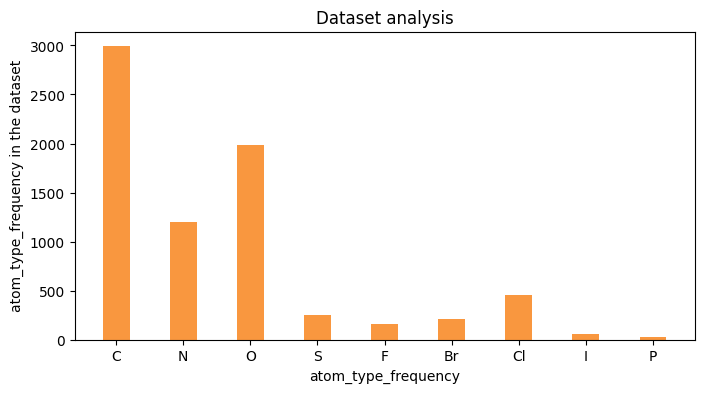

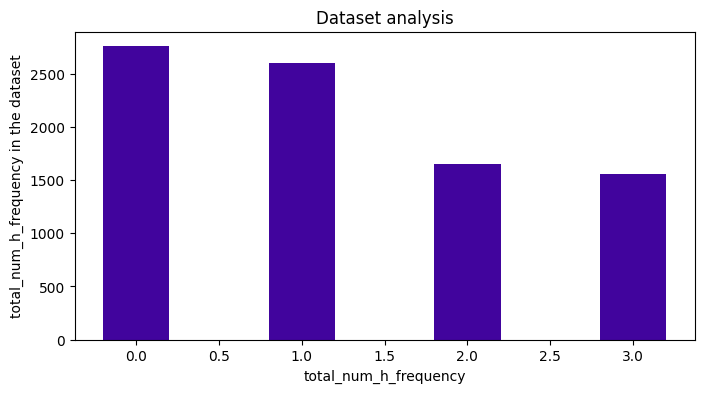

In [24]:
%matplotlib inline

from grape.utils import DataSet
data = DataSet(file_path='/Users/faerte/Desktop/grape/notebooks/data/processed/BradleyDoublePlus.pickle')

results, figures = data.analysis(download=True, plots=['atom_type_frequency','total_num_h_frequency'], fig_size=[8,4])

## Clustering and data splitting
There are several ways to split the graph dataset into the training, validation and testing splits, including random, stratified or by molecular weight. A more novel addition is a split based on **Butina clustering** [2], where the molecules are clustered based on the Morgan Fingerprint and the Tanimoto similarity.


In [25]:
from grape.datasets import BradleyDoublePlus
from grape.utils.data_splitting import taylor_butina_clustering
data = BradleyDoublePlus()

train, val, test = taylor_butina_clustering(data, threshold=0.8, radius=3)

Number of single molecule clusters: 124 and the ratio is: 0.432 of single molecule clusters.


## GNN Model
With the data loaded, filtered, featurizerized and split, let's define a Graph Neural Network and test it! We can always find the number of features like thus:

In [1]:
from grape.utils import DataSet
data = DataSet(file_path='/Users/faerte/Desktop/grape/notebooks/data/processed/BradleyDoublePlus.pickle')
train, test, val = data.get_splits()

print(f'Node feature dimension: {data.num_node_features}')
print(f'Edge feature dimension: {data.num_edge_features}')

Loaded dataset.
Node feature dimension: 42
Edge feature dimension: 12


#### Model definition
To define a model, all we need is the Message Passing Network (like Weave) and a output model. Below, we call the Weave network and wrap it in the ```SimpleGNN``` module, that just adds a global pooling and output layer to the Message Passing network.

In [2]:
from grape.models import MGConv, SimpleGNN
import torch

node_hidden_dim = 64
batch_size = 32

model_message = MGConv(num_layers=5, edge_hidden_dim=64, node_hidden_dim=node_hidden_dim, 
                node_in_dim=data.num_node_features, edge_in_dim=data.num_edge_features)

model = SimpleGNN(model_message=model_message,
                      input_pool_size=node_hidden_dim, 
                      output_size=1)

print(model)

device = torch.device('cpu')

SimpleGNN(
  (model): MGConv(
    (gnn_layers): ModuleList(
      (0-4): 5 x Weave()
    )
  )
  (lin_out): Linear(in_features=64, out_features=1, bias=True)
)


### Loss and Optimizer
Like with any Deep Learning Model, we define a loss function and optimizer.

In [3]:
from torch import nn

loss_func = nn.functional.mse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

### Training
And then we just use the previous found training and validation splits to train the model inside the ```train_model``` function.

In [4]:
from grape.utils import train_model

train_loss, val_loss = train_model(model = model,
                                   loss_func = loss_func,
                                   optimizer = optimizer,
                                   train_data_loader= train,
                                   val_data_loader = val,
                                   batch_size=batch_size,
                                   epochs=100,
                                   early_stopping=True,
                                   patience=20)

epoch=95, training loss= 0.142, validation loss= 0.209: 100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


### Loss plot

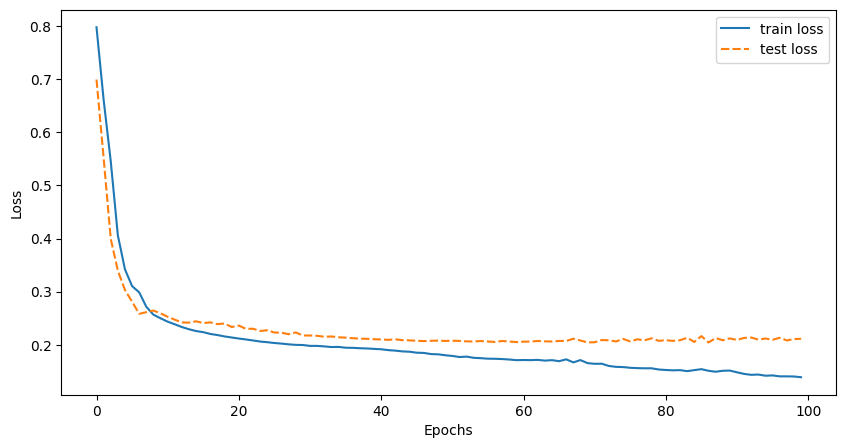

In [5]:
from grape.utils import loss_plot
loss_plot([train_loss, val_loss], ['train loss', 'test loss'])

### Testing

In [6]:
from grape.utils import test_model
test_model(model = model,
           test_data_loader= test,
           loss_func= loss_func);

 20%|██        | 2/10 [00:00<00:00, 37.48it/s]


RuntimeError: stack expects each tensor to be equal size, but got [2, 32] at entry 0 and [32] at entry 1

### Post Processing

With the trained model, we can examine it closer. One way of checking how good a fit is by comparing different losses like MSE, SSE or MAE and seeing where the model might fail:

In [ ]:
from grape.utils import pred_metric

# Generate predictions
preds, lats = test_model(model=model,
                   test_data_loader=test,
                   loss_func=None)


# 

-----

**References**

[1] Feunang, Y., Eisner, R., Knox, C., Chepelev, L., Hastings, J., Owen, G., Fahy, E., Steinbeck, C., Subramanian, S., Bolton, E., Greiner, R., & Wishart, D. S. (2016). ClassyFire: automated chemical classification with a comprehensive, computable taxonomy. Journal of Cheminformatics, 8(1), 61. https://doi.org/10.1186/s13321-016-0174-y

[2] Butina, D. (1999). Unsupervised Data Base Clustering Based on Daylight's Fingerprint and Tanimoto Similarity: A Fast and Automated Way To Cluster Small and Large Data Sets. Journal of Chemical Information and Computer Sciences, 39(4), 747-750. https://doi.org/10.1021/ci9803381